In [1]:
# here, we will 
# calculate predicted slopes for both of our sediment-saturated test cases
# then we will run our model for each other these cases
# using the slope outputs from our model runs, we will create lines using those slopes
# finally, we will make a figure with two horizontal subplots 
# comparing the predicted and actual slopes for each of our test cases

In [2]:
# first import libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# set up arrays and parameters

dx = 1000 # grid spacing
x = np.arange(0, 10000, dx) # domain length
x_node = x + dx/2

U = 0.001 # uplift rate
phi = 0.55 # sediment porosity
kqs = 0.041 # sediment discharge coefficient
I = 0.01 # intermittency factor
r = 10. # runoff rate
kxb = 25 # valley width coeffecient (a, above)
Pxb = (1/5) # valley width exponent

B = kxb * (x_node**Pxb) # valley width   ## TWEAKED
Q = (r * kxb * x**(6/5))/(1 + Pxb) # discharge  ## WE TWEAKED THIS

# for sc1 specifically
z_sc1 = np.linspace(1, 0, len(x)) # starting elevation profile

# for sc2 specifically
z_sc2 = np.linspace(1, 0, len(x)) # starting elevation profile
beta = 0.4 # abrasion factor

### Analytical Solution to Special Case 1: Unlimited sediment, no abrasion, dzdt = 0

In [4]:
# now do predicted slope calculation and line

slope_value_sc1 = ((U * (1-phi) / (kqs * I * r))**(6./7.))
predicted_slope_sc1 = np.zeros(len(x))
predicted_slope_sc1[:] = slope_value_sc1
predicted_topo_sc1 = (-predicted_slope_sc1 * x)

### Analytical Solution to Special Case 2: Unlimited sediment with abrasion, dzdt = 0

In [5]:
# calc the slope with the analytical soln

predicted_slope_sc2 = ((U * B[1:] * x[1:] * (1 - phi))/(1 + (beta * x[1:])) * 1/(kqs*I*Q[1:]))**(6/7)
predicted_topo_sc2 = -(predicted_slope_sc2 * x[1:])

### Model Run for Special Case 1: Unlimited sediment, no abrasion, dzdt = 0

In [6]:
# now create a function for the case SC1 where dzdt=0

def sc1(dx, x, z, U, phi, kqs, I, r, kxb, Pxb, B, Q, num_steps=5000000):
    
    # set timestep
    dt = (0.5 * dx * dx / (kqs*Q[-1]))
    
    # create arrays
    Qs = np.zeros(len(x))
    E = np.zeros(len(x))
    dzdt = np.zeros(len(x))
    
    # set boundary conditions
    Qs[0] = 0
    dzdt[-1] = 0 # dzdt at outlet = 0 for case where dzdt = 0
    
    for i in range(num_steps):
        
        # calculate slope
        S = np.abs(np.diff(z)/dx)
        
        # calculate sediment transport
        ##Qs[1:] = kqs * I * Q[1:] * S**(7./6.)
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.)
        
        # erosion
        # "old" indexing from [:-1]
        E[:-1] = (1/((1-phi)*B[:-1])) * ((np.diff(Qs)/dx))
        
        # calculate rate of elevation change
        # "old" indexing of E from [:-1]
        dzdt[:-1] = U - E[:-1]
        
        # update profile
        z += dzdt * dt
        
    cum_time = num_steps * dt
    # print(cum_time)
        
    return (S, Qs, E, dzdt, z, dt)

In [7]:
# now write a test
sc1_test = [dx, x, z_sc1, U, phi, kqs, I, r, kxb, Pxb, B, Q]

# and run it
S_sc1, Qs_sc1, E_sc1, dzdt_sc1, model_z_sc1, dt_sc1 = sc1(*sc1_test)

In [8]:
# check to make sure we're at steady state
E_sc1

array([0.00099672, 0.00099726, 0.00099774, 0.00099818, 0.00099857,
       0.00099892, 0.00099924, 0.00099952, 0.00099978, 0.        ])

In [10]:
# close enough
# now make a line with the same slopes as those output from the model
model_topo_sc1 = (-S_sc1 * x[1:])

### Model Run for Special Case 2: Unlimited sediment, with abrasion, dzdt = 0

In [11]:
# define a fxn for sc2, dzdt = 0

def sc2(dx, x, z, U, phi, kqs, I, r, kxb, Pxb, beta, B, Q, num_steps=30000):
    
    # set timestep
    dt = (0.5 * dx * dx / (kqs*Q[-1]))
    
    # create arrays
    Qs = np.zeros(len(x))
    E = np.zeros(len(x))
    dzdt = np.zeros(len(x))
    
    # set boundary conditions
    Qs[0] = 0
    #E[-1] = 0
    dzdt[-1] = 0

    for i in range(num_steps):
    
        # calculate slope
        S = np.abs(np.diff(z)/dx)
    
        # calculate sediment transport
        ##Qs[1:] = kqs * I * Q[1:] * S**(7./6.)
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.)
    
        # erosion
        # "old" indexing from [:-1]
        E[:-1] = (1/((1-phi)*B[:-1])) * ((np.diff(Qs)/dx) + (beta * Qs[1:]))
    
        # calculate rate of elevation change
        # "old" indexing of E from [:-1]
        dzdt[:-1] = U - E[:-1]
    
        # update profile
        z += dzdt * dt
    
    return (S, Qs, E, dzdt, z, dt)

In [12]:
# and design a test

sc2_test = [dx, x, z_sc2, U, phi, kqs, I, r, kxb, Pxb, beta, B, Q]

# and run it
S_sc2, Qs_sc2, E_sc2, dzdt_sc2, model_z_sc2, dt_sc2 = sc2(*sc2_test)

In [13]:
# check to make sure we're at steady state
E_sc2

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.   ])

In [14]:
# now make a line with the same slopes as those output from the model
model_topo_sc2 = -(S_sc2 * x[1:])

Text(0.5, 1.0, 'Topography for Case 2: Unlimited sediment, no attrition')

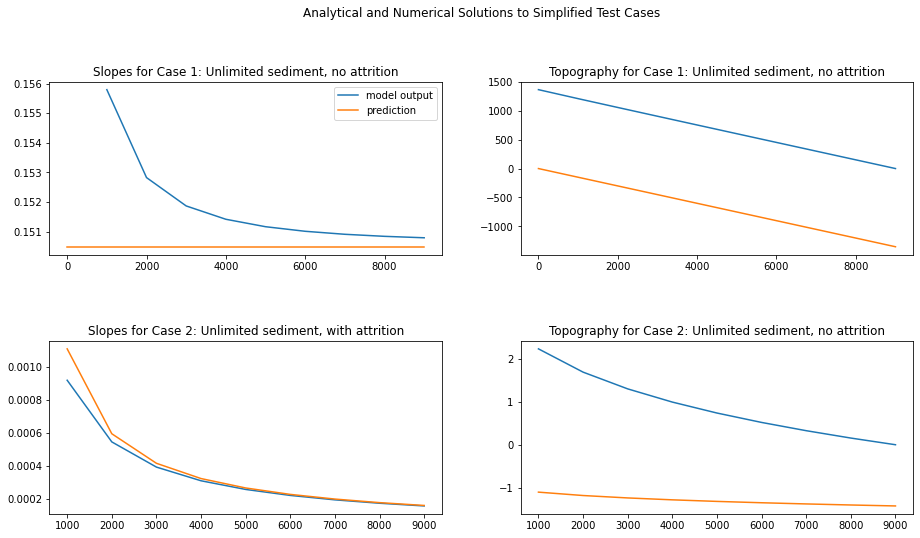

In [28]:
# now plot slopes and elevations
fig, axs = plt.subplots(2, 2, figsize = (15, 8))
fig.suptitle('Analytical and Numerical Solutions to Simplified Test Cases')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.2, 
                    hspace=0.5)

axs[0,0].plot(x[1:], S_sc1, label = 'model output')
axs[0,0].plot(x, predicted_slope_sc1, label = 'prediction')
axs[0,0].set_title('Slopes for Case 1: Unlimited sediment, no attrition')
axs[0,0].legend()

axs[1,0].plot(x[1:], S_sc2)
axs[1,0].plot(x[1:], predicted_slope_sc2)
axs[1,0].set_title('Slopes for Case 2: Unlimited sediment, with attrition')

axs[0,1].plot(x, model_z_sc1)
axs[0,1].plot(x, predicted_topo_sc1)
axs[0,1].set_title('Topography for Case 1: Unlimited sediment, no attrition')

axs[1,1].plot(x[1:], model_z_sc2[1:])
axs[1,1].plot(x[1:], predicted_topo_sc2)
axs[1,1].set_title('Topography for Case 2: Unlimited sediment, no attrition')

In [29]:
S_sc2 - predicted_slope_sc2

array([-1.90096267e-04, -4.93824781e-05, -2.30198333e-05, -1.34456678e-05,
       -8.86997550e-06, -6.31684041e-06, -4.74182360e-06, -3.69912942e-06,
       -2.97167276e-06])

In [30]:
# now test the shape of a prediction for a new special case: with plucking, but without abrasion

r = 10
a = 25
u = 0.001
k = 0.00001
kqs = 0.041
i = 0.01
s0 = 0.15

slope_test = (6/ (5 * r * a * k * x[1:]**(1./5.))) * ((u / (kqs * i * s0)) + (u / x[1:]))

In [31]:
slope_test

array([1960.4968476 , 1706.71158254, 1573.77223675, 1485.77870672,
       1420.92817594, 1370.04829316, 1328.45398959, 1293.44548012,
       1263.33236591])

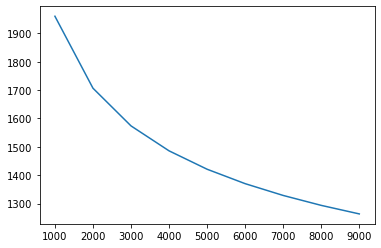

In [32]:
plt.plot(x[1:], slope_test)